### Preamble
Import relevant Python libraries, including Phosphoros plot utilities and NNPZ.

In [1]:
%matplotlib inline
import Euclid
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from astropy.table import Table, join, vstack
from astropy import units as u
from astropy.units import photometric
from astropy.coordinates import SkyCoord
from glob import glob
import healpy
from tqdm.notebook import tqdm

# Silence numpy warnings, since there are NaN around
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
plt.rcParams['figure.figsize'] = (20, 10)

In [3]:
%elogin
%erun Phosphoros
%erun PHZ_NNPZ

In [4]:
from nnpz.reference_sample.ReferenceSample import ReferenceSample
from PhzCLI.PlotSpecZComparison import SpeczPhotozPlot, displayHistogram, compute_stats, boxPlot

# Input catalogs and NNPZ configuration

Read the documentation of the [PhzEASTools](https://gitlab.euclid-sgs.uk/PF-PHZ/PHZ_ToolBox/-/tree/develop/PhzEASTools) to
see how to obtain the MER input catalog and PHZ output catalog.

In [5]:
# Where PhzEASTools stores the data
ppos_dir = os.path.expanduser('~/Work/Data/SC7/Pipelines/')
# PPO to validate
ppo_id = 'PS_DEV_PHZProduction_20200310-VALIDATION-nmorisse-PLAN-0001-2020-04-24-21-48-02-12'
ppo_dir = os.path.join(ppos_dir, ppo_id)

In [6]:
nnpz_config_path = os.path.join(ppo_dir, 'nnpz_prior.conf')
nnpz_config = dict()
exec(open(nnpz_config_path, 'rt').read(), nnpz_config)

## PHZ and MER

In [7]:
# All stats will be done with this point estimate
phz_column = 'REDSHIFT_MODE'

In [8]:
phz_catalog_path = glob(os.path.join(ppo_dir, 'RUN_custom_errors.fits'))[0]
mer_catalog_path = glob(os.path.join(ppo_dir, 'MER_Custom_Errors.fits'))[0]

In [9]:
phz_catalog = Table.read(phz_catalog_path, hdu=1)
mer_catalog = Table.read(mer_catalog_path, hdu=1)

In [10]:
phz_mer_catalog = join(phz_catalog, mer_catalog, 'OBJECT_ID')
print(len(phz_mer_catalog))

68557


## Filter out NaN
If there are any NaN on the Z point estimate, it will propagate and make all stats NaN, so we need to filter them out.

In [11]:
phz_isnan = np.isnan(phz_mer_catalog[phz_column])
if phz_isnan.any():
    print(f'Found {phz_isnan.sum()} records with a NaN PHZ! Removing them.')
    phz_mer_catalog = phz_mer_catalog[phz_isnan == False]

## Compute AB magnitudes
A cut is applied on VIS magnitude, but we compute for all bands here.

In [12]:
for flux in [flux for flux in phz_mer_catalog.colnames if flux.startswith('FLUX_')]:
    band = '_'.join(flux.split('_')[1:-1])
    print(f'Computing MAG_AB_{band}')
    phz_mer_catalog[f'MAG_AB_{band}'] = phz_mer_catalog[flux].to(u.mag(photometric.AB))

Computing MAG_AB_G_EXT_DECAM
Computing MAG_AB_R_EXT_DECAM
Computing MAG_AB_I_EXT_DECAM
Computing MAG_AB_Z_EXT_DECAM
Computing MAG_AB_U_EXT_OMEGACAM
Computing MAG_AB_G_EXT_OMEGACAM
Computing MAG_AB_R_EXT_OMEGACAM
Computing MAG_AB_I_EXT_OMEGACAM
Computing MAG_AB_U_EXT_LSST
Computing MAG_AB_G_EXT_LSST
Computing MAG_AB_R_EXT_LSST
Computing MAG_AB_I_EXT_LSST
Computing MAG_AB_Z_EXT_LSST
Computing MAG_AB_VIS
Computing MAG_AB_Y
Computing MAG_AB_J
Computing MAG_AB_H
Computing MAG_AB_NIR_STACK
Computing MAG_AB_G_EXT_DECAM
Computing MAG_AB_R_EXT_DECAM
Computing MAG_AB_I_EXT_DECAM
Computing MAG_AB_Z_EXT_DECAM
Computing MAG_AB_U_EXT_OMEGACAM
Computing MAG_AB_G_EXT_OMEGACAM
Computing MAG_AB_R_EXT_OMEGACAM
Computing MAG_AB_I_EXT_OMEGACAM
Computing MAG_AB_U_EXT_LSST
Computing MAG_AB_G_EXT_LSST
Computing MAG_AB_R_EXT_LSST
Computing MAG_AB_I_EXT_LSST
Computing MAG_AB_Z_EXT_LSST
Computing MAG_AB_Y
Computing MAG_AB_J
Computing MAG_AB_H
Computing MAG_AB_VIS
Computing MAG_AB_DETECTION


# True Universe
Read only a subset of the columns. We only need sky coordinates for the cross-match and the True Z.

Note that `RA_MAG` and `DEC_MAG` are the coordinates after lensing is applied (observed), so there are the ones that interest us.

In [13]:
tu_columns = ['SOURCE_ID', 'RA_MAG', 'DEC_MAG', 'Z_OBS']

You can obtain the TU tiles from [PIC's WebDAV server](https://shared.euclid.pic.es/SPV/GALAXIES/). The following code helps you to know which tiles
are needed.

In [14]:
mer_tu_tile = healpy.pixelfunc.ang2pix(32, phz_mer_catalog['RIGHT_ASCENSION'], phz_mer_catalog['DECLINATION'], lonlat=True, nest=True)
tu_tiles, tu_tiles_count = np.unique(mer_tu_tile, return_counts=True)
for tile, count in zip(tu_tiles, tu_tiles_count):
    print(f'Need TU Tile {tile} for {count} objects')

Need TU Tile 4208 for 68557 objects


TU catalogs are expected to be stored under `~/Work/Data/SC7/TU/`. Make sure you download the appropiate version.

In [15]:
tu_dir = os.path.expanduser('~/Work/Data/SC7/TU/')
tu_catalogs = []
for tile in tu_tiles:
    tu_catalog_path = glob(os.path.join(tu_dir, f'EUC-GALCAT-*_HPIX_5_NEST_{tile}.fits'))[0]
    tu_catalogs.append(Table.read(tu_catalog_path)[tu_columns])
tu_catalog = vstack(tu_catalogs)
print('Read', len(tu_catalog), 'objects from the TU')

Read 1873604 objects from the TU


## Cross-match with TU Z_OBS

In [16]:
phz_coords = SkyCoord(phz_mer_catalog['RIGHT_ASCENSION'], phz_mer_catalog['DECLINATION'])
tu_coors = SkyCoord(tu_catalog['RA_MAG'] * u.deg, tu_catalog['DEC_MAG'] * u.deg)

In [17]:
tu_idx, tu_distances, _ = phz_coords.match_to_catalog_sky(tu_coors)

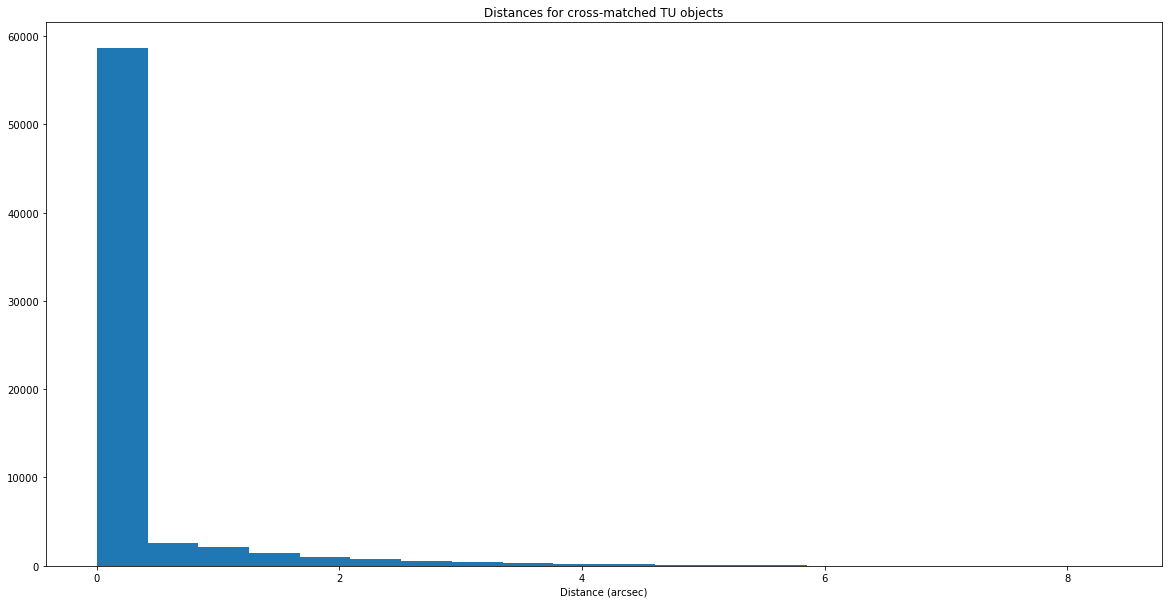

In [18]:
plt.figure()
plt.title('Distances for cross-matched TU objects')
plt.hist(tu_distances.arcsec, bins=20)
plt.xlabel('Distance (arcsec)')
_ = plt.show()

In [19]:
# Restrict to those closer than 1 arcsec to their matching TU object
match_filter = tu_distances <= 1. * u.arcsec
tu_matched = tu_catalog[tu_idx[match_filter]]
phz_matched = phz_mer_catalog[match_filter]
assert len(tu_matched) == len(phz_matched)
print(len(phz_matched))

62200


In [20]:
# Copy Z_OBS
phz_matched['Z_OBS'] = tu_matched['Z_OBS']

## Apply cuts
VIS SNR must be $\ge$ 10, and VIS magnitude cut between 17 and 24.

In [21]:
snr_vis_cut = (phz_matched['FLUX_VIS_APER'] / phz_matched['FLUXERR_VIS_APER'] >= 10)
mag_vis_cut = np.logical_and(phz_matched['MAG_AB_VIS'] >= 17, phz_matched['MAG_AB_VIS'] <= 24.5)

In [22]:
phz_cut_catalog = phz_matched[np.logical_and(snr_vis_cut, mag_vis_cut)]
print(len(phz_cut_catalog))

6608


# Validate with true TU Z

In [23]:
data, mean, median, sigma, mad, outliersPercent,sigmaNoOutliers, meanNoOutliers = compute_stats(phz_cut_catalog['Z_OBS'], phz_cut_catalog[phz_column])

--> Mean                :  -0.013820401
--> Median              :  -0.009175798
--> Sigma               :  0.18600541
--> Mad                 :  0.04245849
--> Outliers            :  14.104116222760291 %
--> Sigma (no outliers) :  0.036712702


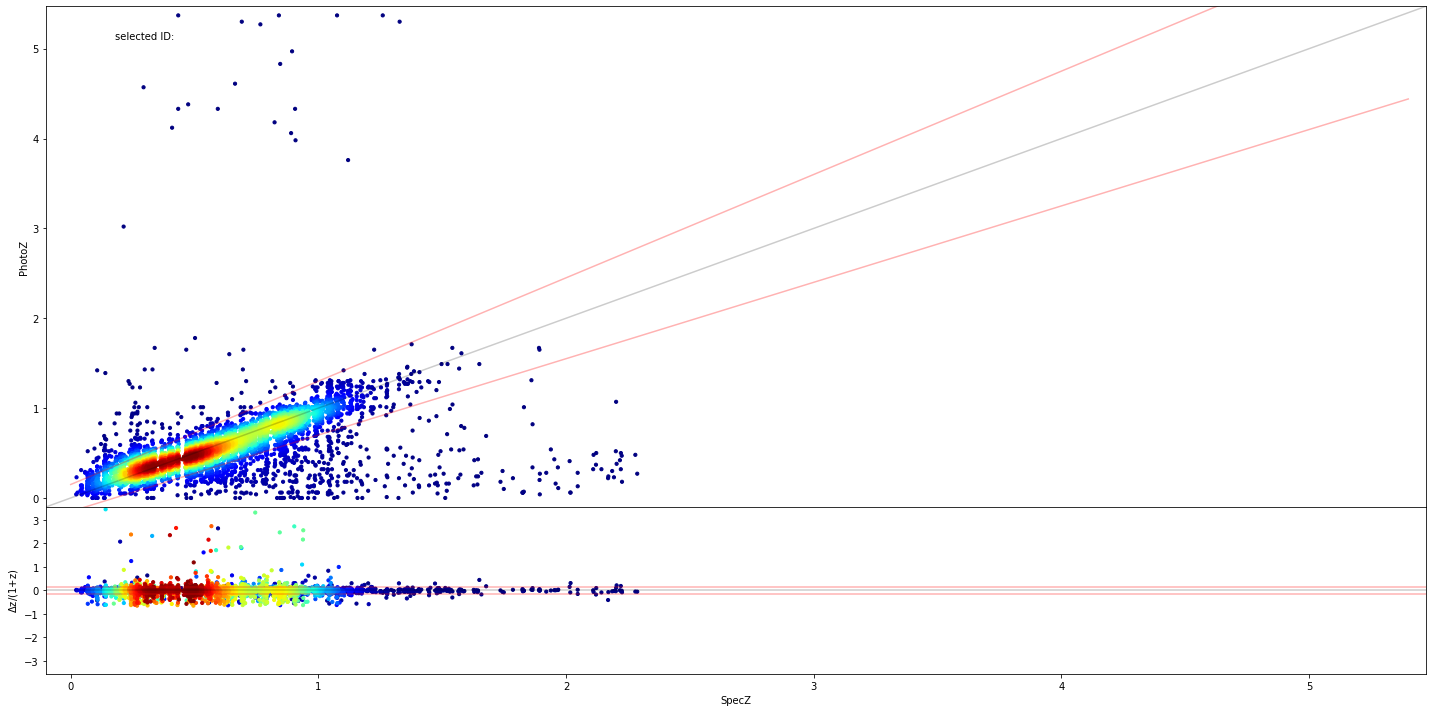

In [24]:
SpeczPhotozPlot(phz_cut_catalog['OBJECT_ID'], phz_cut_catalog['Z_OBS'], phz_cut_catalog[phz_column], data)

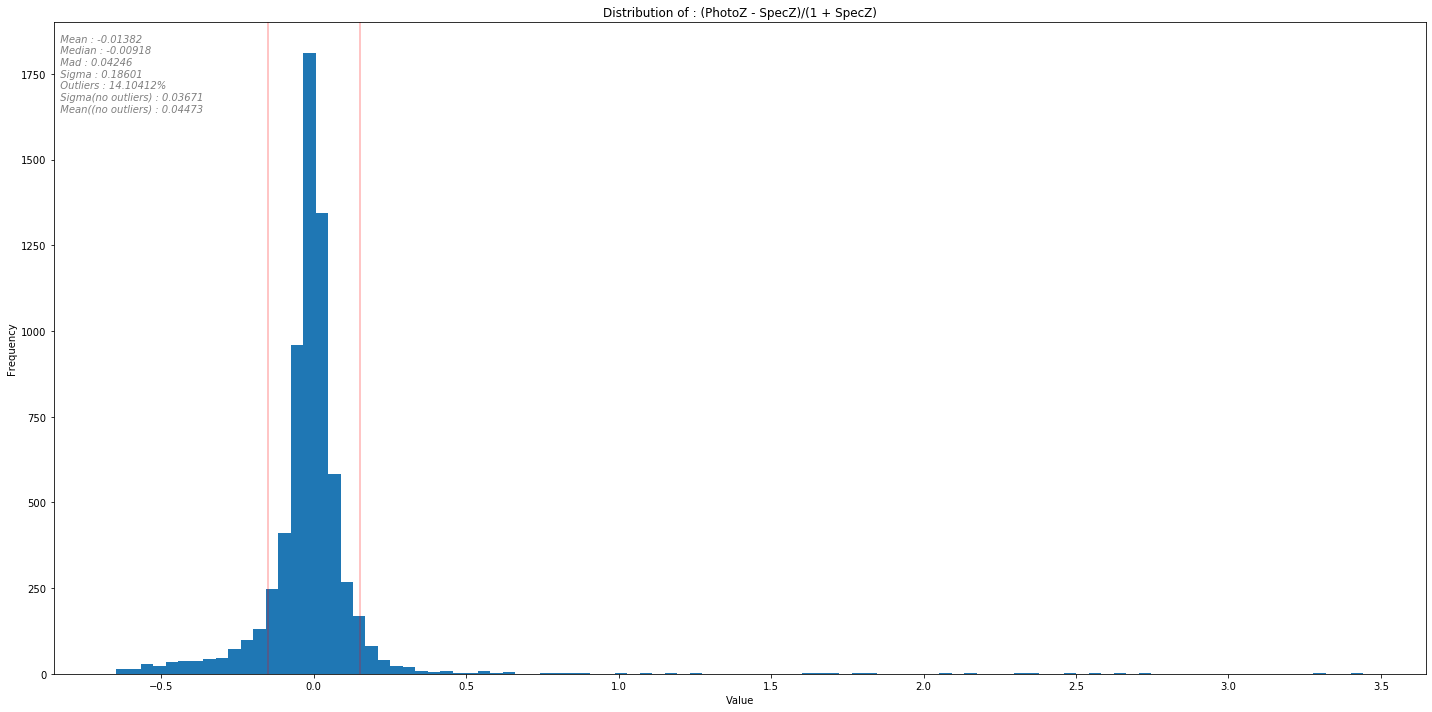

In [25]:
_ = displayHistogram(data, mean, median, mad, sigma, outliersPercent, sigmaNoOutliers, meanNoOutliers)

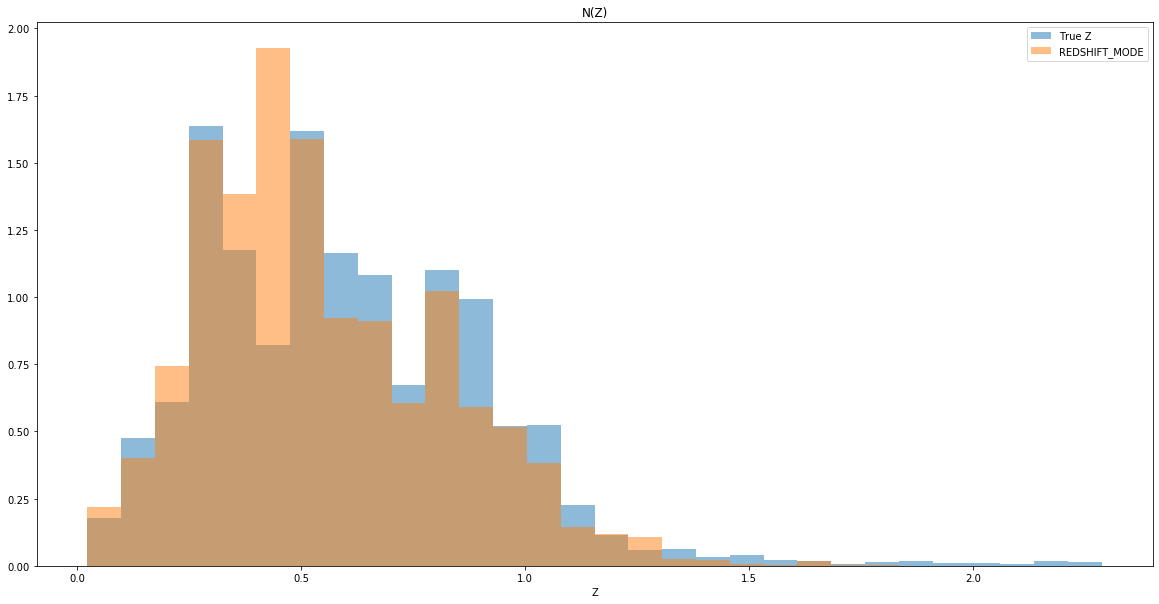

In [26]:
plt.figure()
plt.title('N(Z)')
bins = plt.hist(phz_cut_catalog['Z_OBS'], bins=30, alpha=0.5, density=True, label='True Z')
plt.hist(phz_cut_catalog[phz_column], bins=bins[1], alpha=0.5, density=True, label=phz_column)
plt.xlabel('Z')
plt.legend()
plt.show()

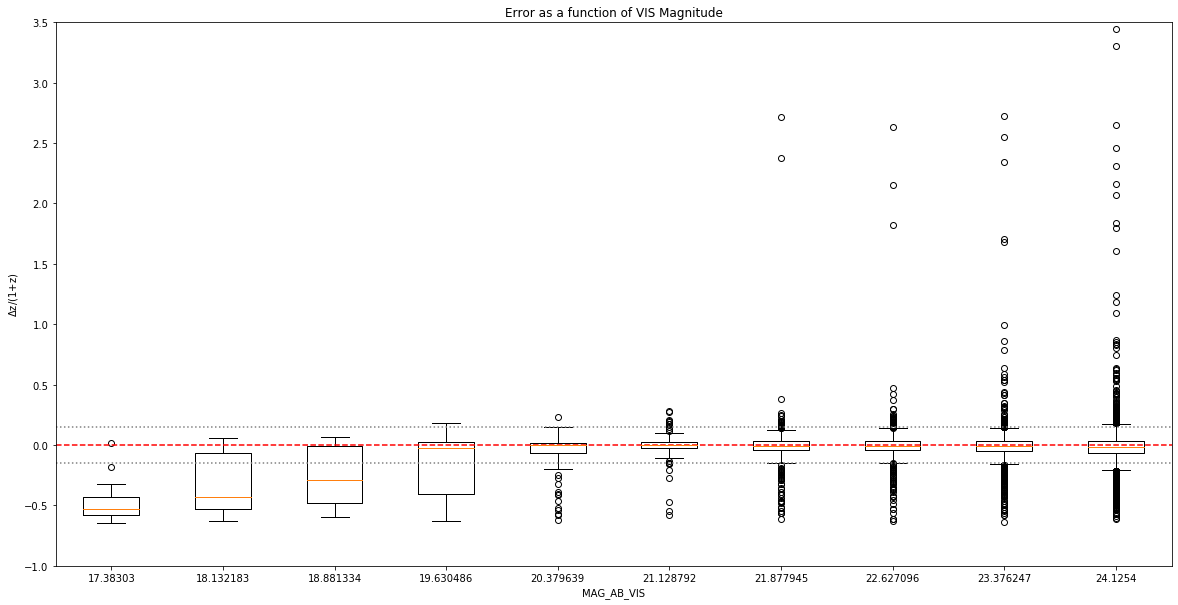

In [27]:
_ = boxPlot(phz_cut_catalog['MAG_AB_VIS'], data)
plt.title('Error as a function of VIS Magnitude')
plt.ylim(-1, 3.5)
plt.show()

# PHZ flagged sources

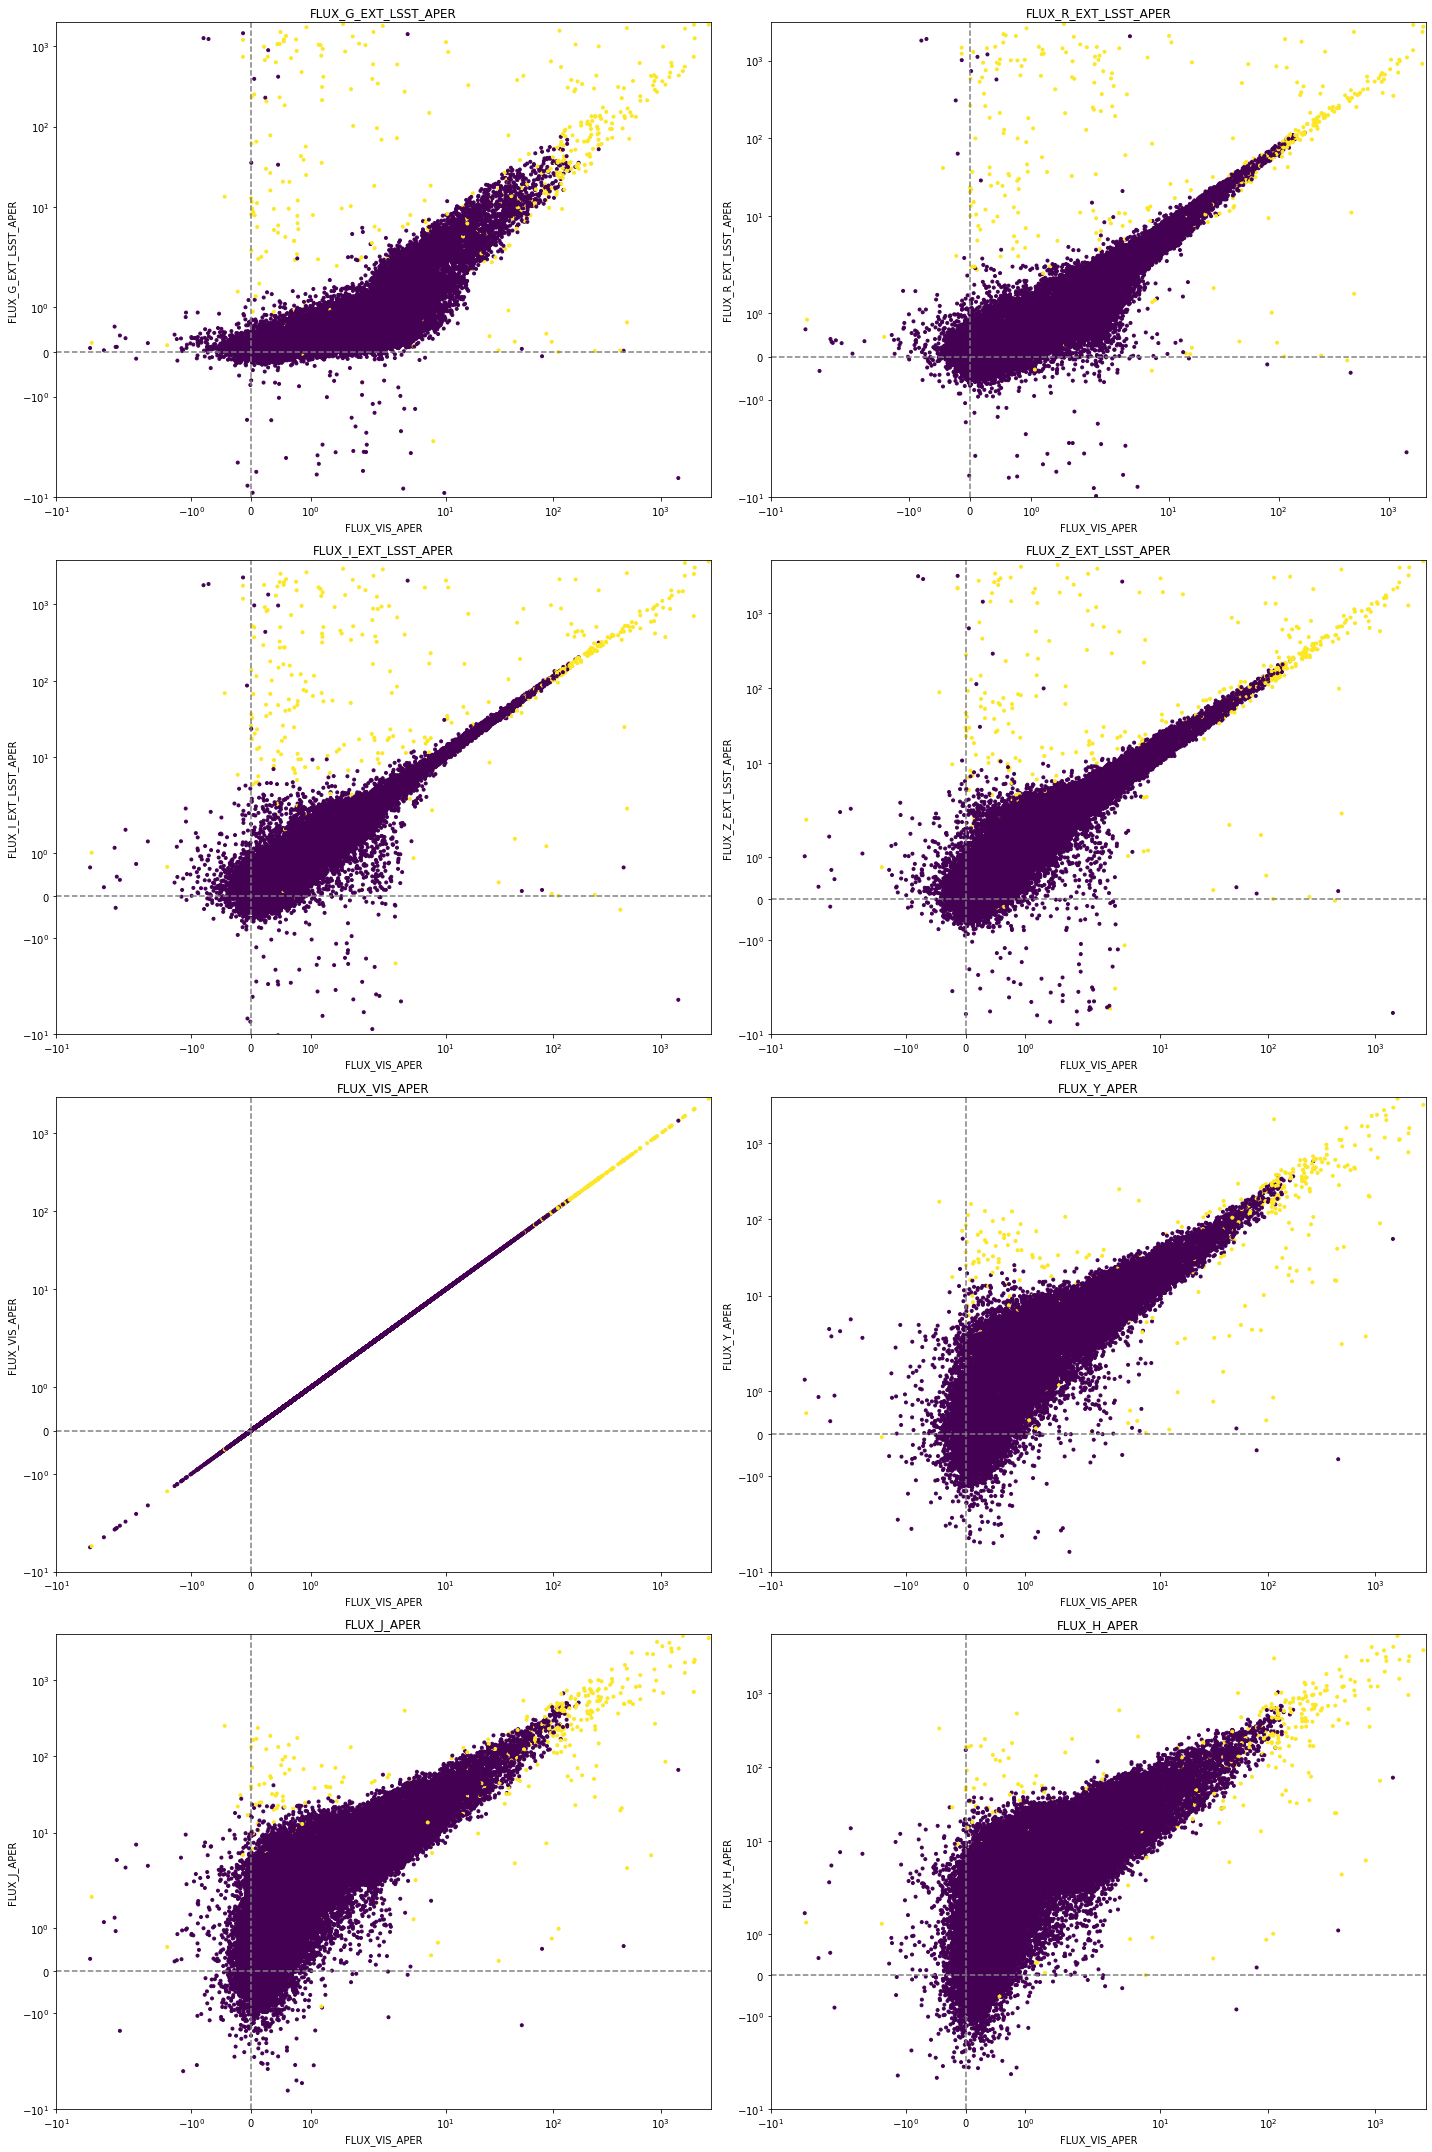

In [28]:
n_filters = len(nnpz_config['target_catalog_filters'])
ncols = 2
nrows = n_filters // ncols + (n_filters % ncols > 0)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 30))
axes = axes.ravel()

vis_min = np.min(phz_matched['FLUX_VIS_APER'])
vis_max = np.max(phz_matched['FLUX_VIS_APER'])

for i, (flux, error) in enumerate(nnpz_config['target_catalog_filters']):
    axes[i].scatter(phz_matched['FLUX_VIS_APER'], phz_matched[flux], marker='.', c=phz_matched['AlternativeWeightFlag'])
    axes[i].set_title(f'{flux}')
    axes[i].set_xlabel('FLUX_VIS_APER')
    axes[i].set_ylabel(flux)
    axes[i].set_xlim(-10)
    axes[i].set_ylim(-10)
    axes[i].plot([vis_min, vis_max], [vis_min, vis_max], c='red', linestyle=':')
    axes[i].axvline(0, 0, 1, c='gray', linestyle='--')
    axes[i].axhline(0, 0, 1, c='gray', linestyle='--')
    axes[i].set_xscale('symlog')
    axes[i].set_yscale('symlog')
    
plt.tight_layout()

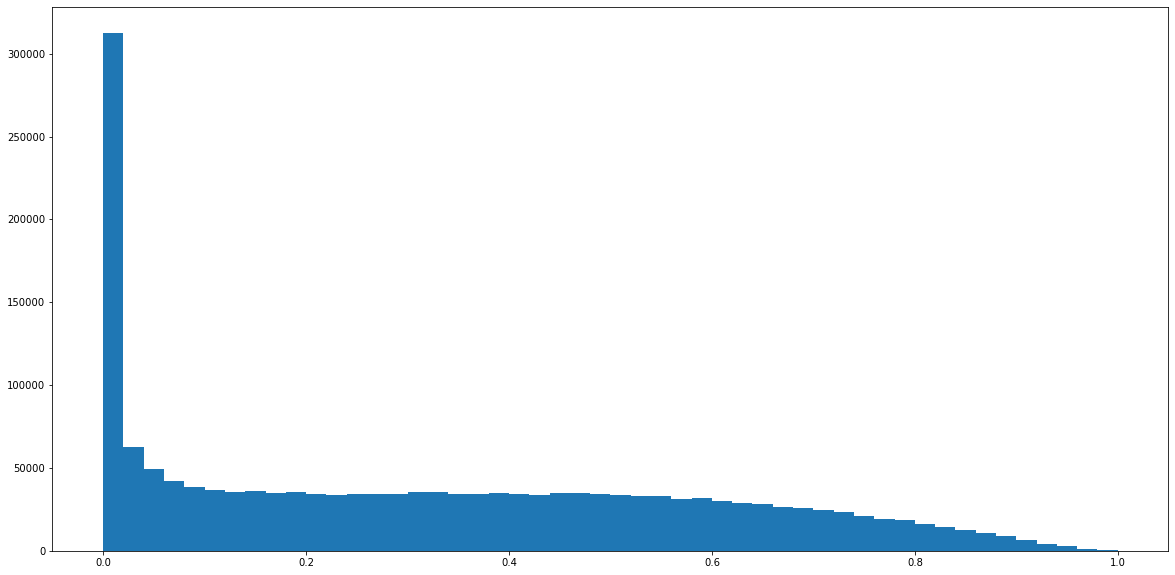

In [29]:
plt.figure()
plt.hist(phz_matched['NEIGHBOR_WEIGHTS'][phz_matched['AlternativeWeightFlag']==False].ravel(), bins=50)
plt.show()

In [30]:
phz_matched['AlternativeWeightFlag'].sum()

492